In [1]:
import torch

In [2]:
PATH = '../downloads/runs/2023-10-16 20-00/yolo_v1_model.pt'
DATASET_PATH = '../downloads/TACO/data'
anns_file_path = DATASET_PATH + '/' + 'annotations.json'

In [3]:
model = torch.load(PATH, map_location=torch.device('cpu'))

c:\Users\USER\Codes\_university\Skripsi-Fauzan_Azmi_Dwicahyo\.venv\lib\site-packages\torch\serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [4]:
from model import numel

print('Number of parameters: %d' % numel(model))

Number of parameters: 267902427


In [5]:
import torchvision.transforms as transforms
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [6]:
from utils import (
    plot_image,
    cellboxes_to_boxes,
    non_max_suppression,
)
from taco_dataset import CoCoDatasetForYOLO

dataset = CoCoDatasetForYOLO(
    root=DATASET_PATH,
    annFile=anns_file_path,
    transform=transform,
    C=1
)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [24]:
idx = 240
data = dataset[idx]

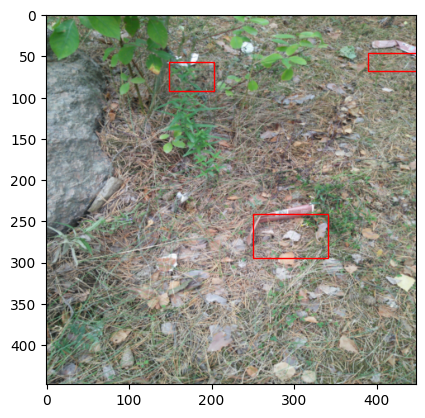

In [25]:
pred = model(data[0].unsqueeze(0))
pred = cellboxes_to_boxes(pred, S=7, B=2, C=1)
pred = non_max_suppression(pred[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(data[0]), pred)

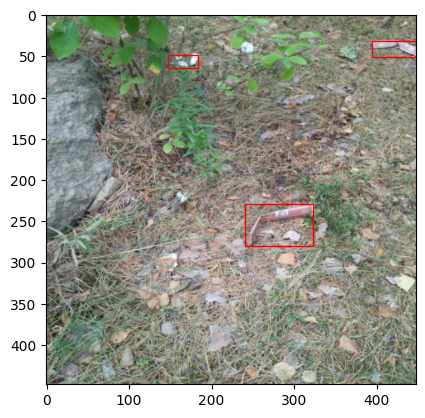

In [26]:
bboxes = cellboxes_to_boxes(torch.tensor([data[1].tolist()]), S=7, B=2, C=1)
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

transform = transforms.ToPILImage()
plot_image(transform(data[0]), bboxes)